In [ ]:
%%capture
!pip install tensorflow
!pip install pandas numpy matplotlib scikit-learn
!pip install opencv-python-headless 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout, Flatten
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import datasets, layers, models
from google.colab import drive
# Dataframes and matrices ---------------------------------------
import numpy as np
import pandas as pd
# Graphics ------------------------------------------------------
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
# Conectamos a GoogleDrive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
BASE_PATH = "/content/drive/My Drive/AI - Proyecto Final/DataSet/images_raw/"

In [ ]:
train_dir = BASE_PATH
validation_dir = BASE_PATH
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1177 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1177 files belonging to 2 classes.


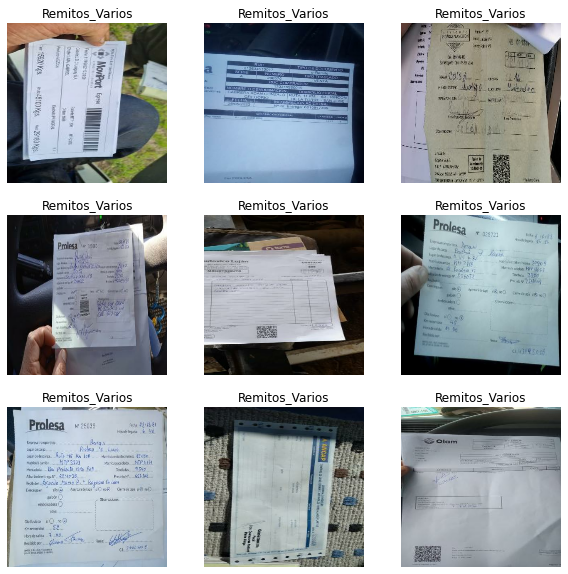

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 30
Number of test batches: 7


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
])

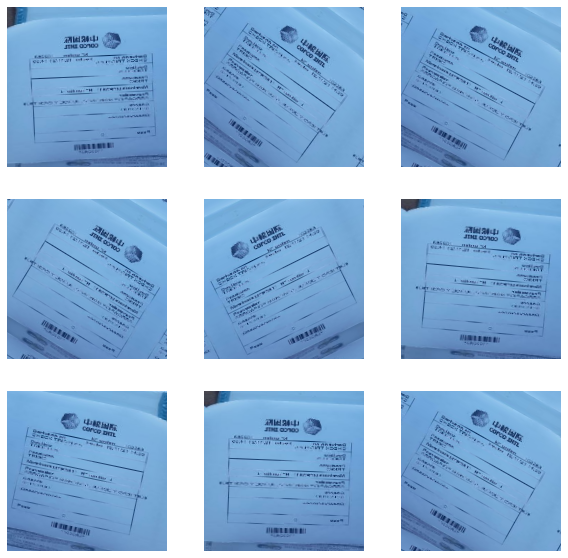

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

30/30 [==============================] - 63s 1s/step - loss: 0.8296 - accuracy: 0.2718


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.27


In [ ]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset) #   , class_weight={1:1,0:5} Juan //    , class_weight={1:1,0:20}   --dar mas pesos a los que tengo menos datos

Epoch 1/50
37/37 [==============================] - 18s 359ms/step - loss: 0.6293 - accuracy: 0.5523 - val_loss: 0.5451 - val_accuracy: 0.6380
Epoch 2/50
37/37 [==============================] - 14s 347ms/step - loss: 0.5370 - accuracy: 0.7239 - val_loss: 0.4958 - val_accuracy: 0.7387
Epoch 3/50
37/37 [==============================] - 14s 331ms/step - loss: 0.4808 - accuracy: 0.8122 - val_loss: 0.4517 - val_accuracy: 0.7891
Epoch 4/50
37/37 [==============================] - 14s 335ms/step - loss: 0.4476 - accuracy: 0.7952 - val_loss: 0.4144 - val_accuracy: 0.8143
Epoch 5/50
37/37 [==============================] - 14s 340ms/step - loss: 0.4365 - accuracy: 0.8165 - val_loss: 0.3921 - val_accuracy: 0.8300
Epoch 6/50
37/37 [==============================] - 14s 346ms/step - loss: 0.4059 - accuracy: 0.8335 - val_loss: 0.3692 - val_accuracy: 0.8531
Epoch 7/50
37/37 [==============================] - 14s 333ms/step - loss: 0.3720 - accuracy: 0.8471 - val_loss: 0.3451 - val_accuracy: 0.8720

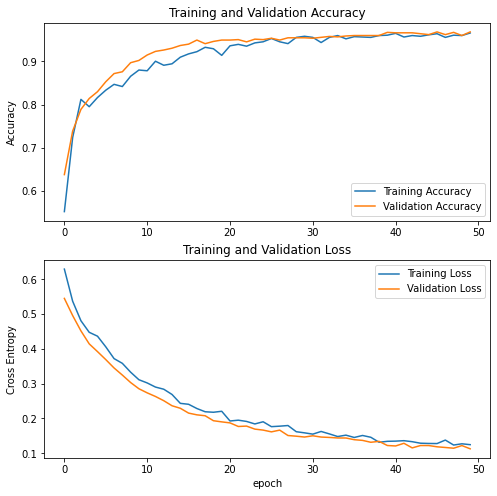

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

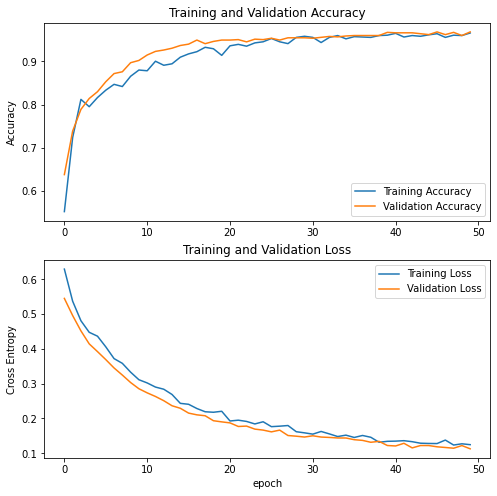

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('remito_model.h5')

In [ ]:
# guardo modelo en drive
model.save(BASE_PATH + 'remito_model.h5')

In [ ]:
#model.save('remito_model_class_weight.h5')

In [ ]:
def load_img(filename):
    img_resized = None
    IMAGE_WIDTH=160
    IMAGE_HEIGHT=160 
    img = cv2.imread(filename)
    try:
        img_resized = cv2.resize(img,(IMAGE_WIDTH,IMAGE_HEIGHT))
    except:
        print(f'Error in image {img}')
    return img_resized

In [ ]:
from keras.preprocessing import image
from keras.models import load_model
#saved_model = load_model("remito_model_class_weight.h5") 
saved_model = load_model("remito_model.h5") 
#remito_model.h5

Remito_OK tf.Tensor([[0.06160891]], shape=(1, 1), dtype=float32)


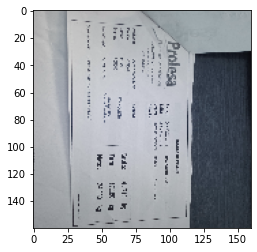

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112539.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
output = tf.nn.sigmoid(output)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

Remito_OK tf.Tensor([[0.04650988]], shape=(1, 1), dtype=float32)


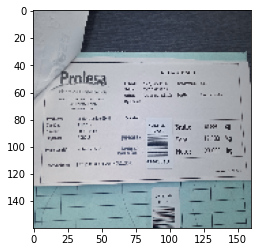

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112226.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
output = tf.nn.sigmoid(output)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

Remito_OK tf.Tensor([[0.03442963]], shape=(1, 1), dtype=float32)


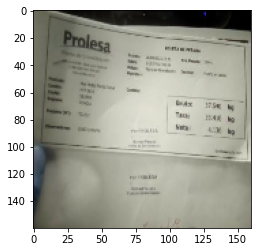

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/11840.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
output = tf.nn.sigmoid(output)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

Remitos_Varios tf.Tensor([[0.73513365]], shape=(1, 1), dtype=float32)


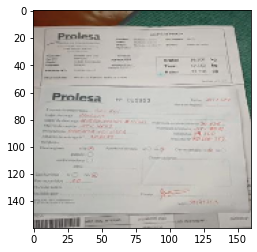

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/11839.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
output = tf.nn.sigmoid(output)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

Remitos_Varios tf.Tensor([[0.97368467]], shape=(1, 1), dtype=float32)


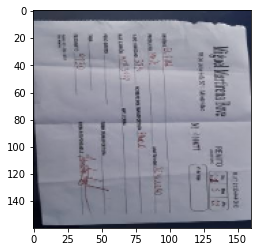

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remitos_Varios/12058.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
output = tf.nn.sigmoid(output)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

In [ ]:
IMG_DIR_TEST_OK= '/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK'
IMG_DIR_TEST_VARIOS = '/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remitos_Varios'

data_test_ok = []
for filename in os.listdir(IMG_DIR_TEST_OK):
  data_test_ok.append({"image_name": 'Remito_OK/' + filename, "isValid": 0, 'isValidModel': None})

data_test_varios = []
for filename in os.listdir(IMG_DIR_TEST_VARIOS):
  data_test_varios.append({"image_name": 'Remitos_Varios/' + filename, 'isValid': 1,'isValidModel': None})

df_ok = pd.DataFrame(data_test_ok)
df_varios = pd.DataFrame(data_test_varios)
df_result = pd.concat([df_ok, df_varios])
df_result

isValidModel = []
probability = []
for index, row in df_result.iterrows():
  try:
    image = '/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/'+ row["image_name"]
    print(image)
    img = load_img(image)
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    output = saved_model.predict(img)
    output = tf.nn.sigmoid(output)
    if output[0] > 0.5:
      isValidModel.append(1)
      probability.append(float(output[0][0]))
    else:
      isValidModel.append(0)
      probability.append(float(output[0][0]))
  except:
    print('No se procesa img')

df_result['isValidModel'] = isValidModel
df_result['modelProbability'] = probability

/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112226.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112236.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112247.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112256.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112304.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112514.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112523.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112537.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/IMG_20220817_112539.jpg
/content/drive/My Drive/AI - Proyecto Final/DataSet/ima

In [ ]:
df_result

,image_name,isValid,isValidModel,modelProbability
0,Remito_OK/IMG_20220817_112226.jpg,0,0,0.046510
1,Remito_OK/IMG_20220817_112236.jpg,0,0,0.080821
2,Remito_OK/IMG_20220817_112247.jpg,0,0,0.012443
3,Remito_OK/IMG_20220817_112256.jpg,0,0,0.020439
4,Remito_OK/IMG_20220817_112304.jpg,0,0,0.013585
5,Remito_OK/IMG_20220817_112514.jpg,0,0,0.030481
6,Remito_OK/IMG_20220817_112523.jpg,0,0,0.034628
7,Remito_OK/IMG_20220817_112537.jpg,0,0,0.021586
8,Remito_OK/IMG_20220817_112539.jpg,0,0,0.061609
9,Remito_OK/IMG_20220817_112551.jpg,0,0,0.131043


Remitos_Varios tf.Tensor([[0.73513365]], shape=(1, 1), dtype=float32)


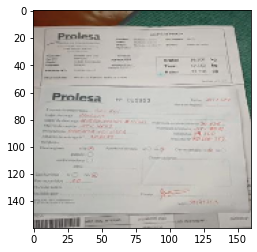

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/imagenesModel/test/Remito_OK/11839.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
output = tf.nn.sigmoid(output)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

Remito_OK tf.Tensor([[0.03013235]], shape=(1, 1), dtype=float32)


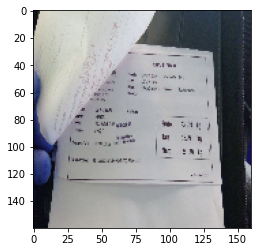

In [ ]:
img = load_img('/content/drive/My Drive/AI - Proyecto Final/DataSet/testNew/test11.jpg') #,target_size=(200,200)
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)
output = tf.nn.sigmoid(output)
if output[0] > 0.5:
    print("Remitos_Varios",output)
else:
    print('Remito_OK', output)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_result['isValid'], df_result['isValidModel']))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.93      1.00      0.96        13

    accuracy                           0.96        26
   macro avg       0.96      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_result['isValid'], df_result['isValidModel'])

array([[12,  1],
       [ 0, 13]])

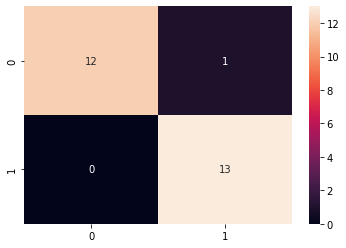

In [ ]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(df_result['isValid'], df_result['isValidModel'])
sns.heatmap(cf_matrix, annot=True)
plt.show()